# EECS 595 HW3: Parts 5: Fine-Tuning BERT for Classification

In Parts 1 to 3, you built and pre-trained a tiny BERT-like model for the langauge of product reviews. Pre-training is exciting and necessary, but the real power comes from adapting a pre-trained model's parameters to a particular task. Now that you have a copy of that model saved, let's try to adapt it for the same classification task as in Homework 2: sentiment analysis. 

To start, like in Part 4, you'll need to import the relevant code from BERT into this notebook. You can either do this with a copy/paste if your code is finalized, or if you have your code as a script somewhere (e.g., for submitting to Great Lakes for training), you can import the classes and methods with `import` statements from that file, e.g., something like `from myfile import BERT`. The latter approach is probably better since it will make this notebook much less cluttered and reduce any chances for typos/missing pieces when copying.

*Part 5* will have you test out the "classification" mode of the `BERT` model you implemented. Here, you'll once again need to write a `Dataset` and `collator` function to read in the sentiment data. These are _very_ common steps you'll need as a practitioner (since you'll mostly be starting from pre-trained models), so we wanted to give you practice. The code will look similar to what you had in Part 3 too.

**Important Note:** You can run this notebook to test your initial pre-trained model from your CPU for classification. However, all of tasks should be done using the fully-trained version you get from Great Lakes.


In [12]:
import os
import math
import numpy as np
import random
import logging

# Bring in PyTorch
import torch
import torch.nn as nn

# Most of the examples have typing on the signatures for readability
from typing import Optional, Callable, List, Tuple
from copy import deepcopy
# For data loading
from torch.utils.data import Dataset, IterableDataset, TensorDataset, DataLoader
import json
import glob
import gzip
import bz2
import wandb

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, recall_score, precision_score

import pandas as pd

import matplotlib.pyplot as plt

# For progress and timing
from tqdm.auto import tqdm, trange
import time

# check if gpu is available
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
print(f"Using '{device}' device")

Using 'cpu' device


## Part 5.0: Be able to run BERT

You'll need to have the `BERT` class in this notebook to run BERT so import (or copy) all the necessary code in the cell below. It's better to import the classes/functions from the file you used to submit to Great Lakes since that code works. This can/should be the same code you used in Part 4.0 during your BERT exploration.

In [13]:
################################################################
#                     TODO: YOUR CODE HERE                     #
#
# 1. Create a tokenizer for the BERT model
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer("vocab.txt")
# 2. Import (or copy) all the necessary code to run the BERT model. 
import import_ipynb
from Pre_train_BERT_Student import BERT
#
################################################################
 


## Part 5.1 Build a `Dataset` for Sentiment Classification

To train the model, we'll create a new `Dataset` that turns our text data into sequences of token IDs. This code will look similar to what we have in the MLM `Dataset` class.

In [14]:

class_train_path = './sentiment.train.csv' # column names: sentence, label
class_test_path = './sentiment.dev.csv' # column names: sentence, label

class ClassificationDataset(Dataset):
    def __init__(self, tokenizer, data_filename: str, max_len=128):

        ############################################################
        #             TODO: YOUR CODE                              #
        # 
        # 1 save the arguments and load the data from the specified file
        self.tokenizer = tokenizer
        self.data = pd.read_csv(data_filename)
        self.max_len = max_len
        ############################################################        

    def __len__(self):
        return len(self.data)
    
    def tokenize_and_prepare(self):
        ############################################################
        #             TODO: YOUR CODE                              #
        #
        # 1. Tokenize the data and prepare it for the model
        self.token_ids = []
        self.labels = []
        for index, row in tqdm(self.data.iterrows()):
            ids = tokenizer.encode(row[0]).ids[:self.max_len]
            ids[-1] = 102
            self.token_ids.append(ids)
            self.labels.append(row[1])
        # NOTE: for memory efficiency, you can delete the data field 
        # after tokenizing the data and just retain the tokenized version
        ############################################################

    def __getitem__(self, idx):
        ############################################################
        #                   TODO: YOUR CODE                        #
        #
        # 1. Look up the tokenized data and label for the specified index
        token_ids = deepcopy(self.token_ids[idx])
        label = deepcopy(self.labels[idx])
        # 2. Create an attention mask for the data
        mask = [True] * len(token_ids)
        # 3. Return the ids, attention mask, and label
        return token_ids, mask, label
        ############################################################

## Part 5.2: Implement a collate function for sentiment data

Just like in our MLM training for BERT, we'll need another collator function that turns sequences into batches. Your collate function will look similar to what you had for MLM.

In [15]:
def classification_collate_fn(batch):
    '''
    Collate function for the classification dataset.

    Args:
    - batch: list of tuples of the form (input_ids, attention_mask, label)
    '''
    ############################################################
    #                     TODO: YOUR CODE                      #
    input_ids_list = [torch.tensor(i[0]) for i in batch]
    mask_list = [torch.tensor(i[1]) for i in batch]
    labels = [torch.tensor(i[2]) for i in batch]
    # 1. Pad the input_ids and attention_mask
    padded_input_ids = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=0)
    padded_masks = torch.nn.utils.rnn.pad_sequence(mask_list, batch_first=True, padding_value=False) 
    # 2. Return the input_ids, attention_mask, and labels as a tuple
    return padded_input_ids, padded_masks, torch.tensor(labels)
    ############################################################


In [16]:
# test the collate function
batch_size = 8
classification_dataset = ClassificationDataset(tokenizer, class_train_path)
classification_dataset.tokenize_and_prepare()
classification_dataloader = DataLoader(classification_dataset, batch_size=batch_size, shuffle=False, collate_fn=classification_collate_fn)


for input_ids, attention_mask, labels in classification_dataloader:
    print(input_ids.shape)
    print(attention_mask.shape)
    print(labels.shape)
    break

0it [00:00, ?it/s]

torch.Size([8, 48])
torch.Size([8, 48])
torch.Size([8])


## Part 5.4 Load in the development data

During training, we'll want to evaluate our model: how well is it doing over time? We can use the performance metrics to do model selection and choose what's our "best" model for evaluating or use in production.

The first part is relatively straightforward part: Load in the development data like you loaded in the training data. We'll use it later when training for some evaluation.

The second part will be to write our `evaluate_model` function that will take in a model and a `DataLoader` (e.g,. for the development data) and return the scores. We'll call this function periodically during training to get an updated estimate of how well the model is learning and performing.

In [17]:
batch_size = 8

################################################################
#             TODO: YOUR CODE                                  #
# 1. Load a classification dataset for the dev data
dataset = ClassificationDataset(tokenizer, class_test_path, max_len=128)
dataset.tokenize_and_prepare()
# 2. Create a dataloader for the dev data
devloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=classification_collate_fn)
#
################################################################


def evaluate_model(model, dataloader, device):
    '''
    Returns the precision, recall, and f1-score of the model on the data in the specified dataloader.
    '''

    ################################################################
    #             TODO: YOUR CODE                                  #
    #
    # 1. Set the model to evaluation mode
    model.eval()
    
    predictions = []
    labels = []
    # 2. Iterate through the dataloader and make predictions
    with torch.no_grad():
        for input_ids, attention_mask, label in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)

            
            output, attn = model(input_ids, attention_mask)
            output = output.argmax(dim=1)
            labels.extend(label.cpu().numpy())
            predictions.extend(output.cpu().numpy())
        
        model.train()
        # 3. Calculate the precision, recall, and f1-score
        precision = precision_score(labels, predictions)
        recall = recall_score(labels, predictions)
        f1 = f1_score(labels, predictions)
    
        return precision, recall, f1
    #
    # HINT: You can use sklearn.metrics to calculate the metrics
    ################################################################



0it [00:00, ?it/s]

## Part 5.5 Fine-Tune a BERT Classifier

Let's put those pre-trained parameters to work! Using your BERT model for classification, this part will have you write a training loop. The training loop will look similar to those you have done before at this point.

For this part of the assignment, you can train it entirely on your laptop. The dataset should fit and be relatively fast to train. For some reference, on a macbook M1, training with a batch size of 8 takes around 7 minutes for one epoch using 'mps' and 25 minutes with 'cpu'. The model and data both fit in 8GB.

When training, we'll periodically call `evaluate_model` to score the current parameters. It's common to choose one metric to consider what is the "best" and then save those parameters so that at the end of training, you can load back in which model did best. We'll do the same here using the F1 score. Be sure to save this classifier model to a different filename (different from the MLM pre-trained model's one!) so you can load it back it.

We'll add a bit more fancy Weights & Biases instrumentation for training our model here. Specifically, in addition to reporting loss, we'll also periodically score the model on the evaluation set and report those numbers to `wandb` every 1000 steps. When training large models, it's helpful to not only get a sense of the loss but also the model's performance on the task you actually want it to do. Often loss and task-specific performance are closely correlated, but not always! The plots on `wandb` can help show us when we can stop training by looking at when the task-specific performance converges; the model's loss may continue to go down, but this could be that the model is overfitting. See the wandb [documentation](https://docs.wandb.ai/guides/track/launch) for examples on how to log metrics.

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Step:   0%|          | 0/20000 [00:00<?, ?it/s]

Step:   0%|          | 0/20000 [00:00<?, ?it/s]

Step:   0%|          | 0/20000 [00:00<?, ?it/s]

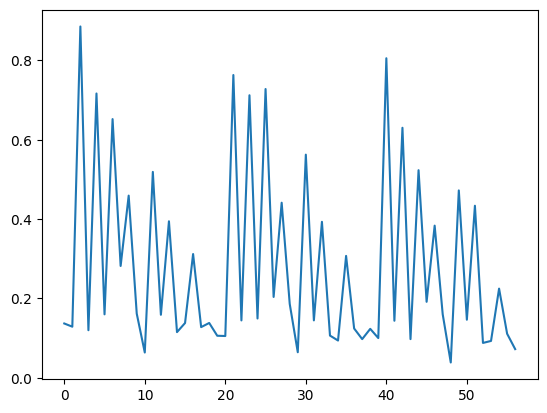

In [19]:
################################################################
#             TODO: YOUR CODE                                  #
#
# 1. Define the hyperparameters, loss function, optimizer, etc. for training
bert = BERT(vocab_size=tokenizer.get_vocab_size(),
    feed_forward_size= 256,
    hidden_size= 128,
    num_layers= 2,
    num_heads= 4,
    mode = 'classification',
    num_classes=2)
bert.load_state_dict(torch.load("best_f1.sd", map_location=torch.device('cpu')), strict=False)
bert.to(device)
bert.train()

optimizer = torch.optim.AdamW(bert.parameters(), lr=2e-5)
f_loss = nn.CrossEntropyLoss()

num_epochs = 3
# 2. Initialize wandb 
wandb.init(project='EECS595-BERT-Class', name=f'experiment-{time.time()}')
wandb.watch(bert, log_freq=1000)
#
################################################################


# Keep track of the losses for quick plotting after
losses = []
best_f1 = -1.0
f1 = -2.0
# Train the model
for epoch in range(num_epochs):
    for step, (input_ids, attention_mask, labels) in enumerate(tqdm(classification_dataloader, position=1, leave=True, desc="Step")):
        ################################################################
        #             TODO: YOUR CODE                                  #
        #
        #send to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        # 2. Zero the gradients of the optimizer.                     #
        optimizer.zero_grad()
        # 1. Predict the instances in the batch
        outputs, attn = bert(input_ids)
        # 2. Compute the loss and update the weights
        loss = f_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        # 3. Every `reporting_interval` batches, score the model on the 
        #    dev data using the `evaluate_model` function and report those scores to wandb
        if (step % 1000 == 0 and step != 0):
            wandb.log({"loss": loss.item()})
            losses.append(loss.item())
            precision, recall, f1 = evaluate_model(bert, devloader, device)
            wandb.log({"Precision": precision, "F1 Score": f1, "Recall": recall})
        # 4. Keep track of the model parameters with the best f1 score and save it to disk
        if f1 > best_f1:
            best_f1 = f1 
            torch.save(bert.state_dict(), f"best_f1.sd")
        #
        ################################################################


plt.plot(losses)

## Part 5.6 Evaluate on the test data

Once you've finished training, let's see how well our best model does on the test data. Do the following steps:

1. Load in the best model's parameters from your saved file so that we can use it for classification on the test data
2. Create a `Dataset` instances and `DataLoader` for the test data
3. Generate the prediction file for the test data (this code will look similar to `evaluate_model`)
4. Upload the predictions to Kaggle.

The test data format to upload to kaggle is the same as in Homework 2.


In [21]:
class TestingDataset(Dataset):
    def __init__(self, tokenizer, max_len=128):

        ############################################################
        #             TODO: YOUR CODE                              #
        # 
        # 1 save the arguments and load the data from the specified file
        self.tokenizer = tokenizer
        self.data = pd.read_csv('./sentiment.test.csv')
        self.max_len = max_len
        ############################################################        

    def __len__(self):
        return len(self.data)
    
    def tokenize_and_prepare(self):
        ############################################################
        #             TODO: YOUR CODE                              #
        #
        # 1. Tokenize the data and prepare it for the model
        self.token_ids = []
        self.inst_ids = []
        for index, row in tqdm(self.data.iterrows()):
            self.inst_ids.append(row[0])
            ids = tokenizer.encode(row[1]).ids[:self.max_len]
            self.token_ids.append(ids)

        # NOTE: for memory efficiency, you can delete the data field 
        # after tokenizing the data and just retain the tokenized version
        ############################################################

    def __getitem__(self, idx):
        ############################################################
        #                   TODO: YOUR CODE                        #
        #
        # 1. Look up the tokenized data and label for the specified index
        token_ids = deepcopy(self.token_ids[idx])
        inst_ids = deepcopy(self.inst_ids[idx])
        # 2. Create an attention mask for the data
        mask = [True] * len(token_ids)
        # 3. Return the ids, attention mask, and label
        return token_ids, mask, inst_ids
        ############################################################

In [22]:
import csv
################################################################
#             TODO: YOUR CODE                                  #
# 1. Load a classification dataset for the test data
dataset = TestingDataset(tokenizer, max_len=128)
dataset.tokenize_and_prepare()
# 2. Create a dataloader for the dev data
testloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=classification_collate_fn)

best_bert = BERT(vocab_size=tokenizer.get_vocab_size(),
    feed_forward_size= 256,
    hidden_size= 128,
    num_layers= 2,
    num_heads= 4,
    mode = 'classification',
    num_classes=2)
best_bert.load_state_dict(torch.load("best_f1.sd", map_location=torch.device('cpu')), strict=False)
best_bert.eval()
with open('ptKaggle.csv', 'w', newline='') as csv_file:
    filewriter = csv.writer(csv_file, delimiter= ',')
    filewriter.writerow(['inst_id', 'Label'])
    with torch.no_grad():
            for input_ids, attention_mask, inst_id in tqdm(testloader):
                output, attn = best_bert(input_ids, attention_mask)
                output = output.argmax(dim=1)
                filewriter.writerow([inst_id.item(), output.item()])
################################################################

0it [00:00, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


## Optional Visualization

If you're curious try putting in some example text and visualizing what the classification model's different heads are looking at. You can also try contrast the attention focus with the original pre-trained BERT (you'll need to load this in separately).

torch.Size([2, 1, 4, 15, 15])


IndexError: index 1 is out of bounds for dimension 0 with size 1

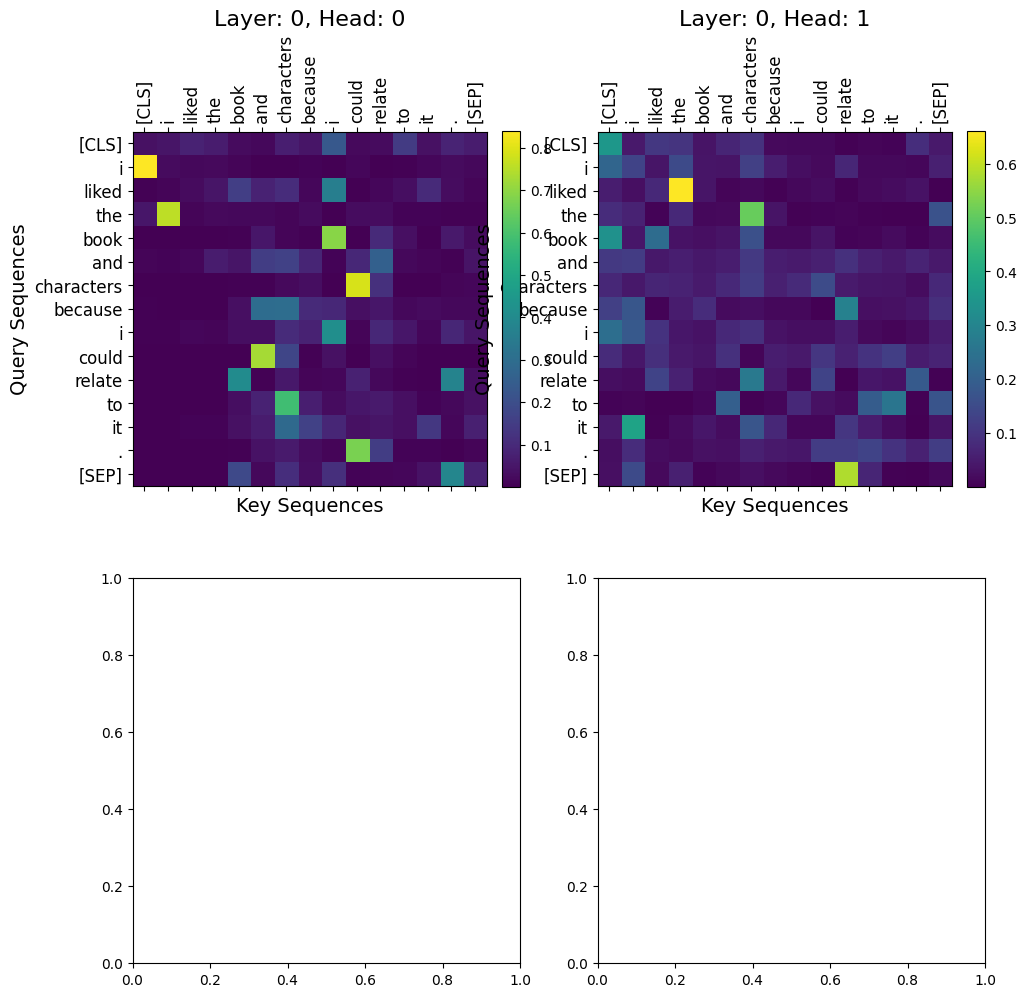

In [ ]:
################################################################
# The visualization code below is provided for you. You can use it to visualize the attention weights of the BERT model.
# It takes the list of layer/head indices so that you can compare the attention weights across difference layers/heads

def attention_visualizer(sentence, model, tokenizer, layers=[-1], heads=[-1]):
    model.eval()
    with torch.no_grad():
        # Encode the sentence
        tokenized_input = tokenizer.encode(sentence)
        ids = tokenized_input.ids
        
        # Forward pass to get attention weights
        _, attns = model(torch.tensor([ids]).to(device))
        print(attns.shape)
        
        # Determine the number of layers and heads to compare
        num_layers = len(layers)
        num_heads = len(heads)
        
        # Set up the figure for subplots
        fig, axs = plt.subplots(num_layers, num_heads, figsize=(num_heads*5.5, num_layers*5.5))
        
        # Handle the case for single subplot to maintain consistency
        if num_layers == 1 and num_heads == 1:
            axs = np.array([[axs]])
        
        # Convert axs to an array for easy indexing if it's not already
        if not isinstance(axs, np.ndarray):
            axs = np.array(axs)
        
        # Ensure axs is 2D
        if axs.ndim == 1:
            axs = np.expand_dims(axs, axis=0 if num_layers == 1 else 1)
        
        for i, layer in enumerate(layers):
            for j, head in enumerate(heads):
                # attn has shape [B, L, H, T_q, T_k]
                attn = attns[0][layer, head, :, :]
                
                # Extract the attention weights for visualization
                attn_weights = attn.squeeze(0).cpu().numpy()
                
                # Get the tokens for labels
                tokens = tokenized_input.tokens
                
                # Plot the attention heatmap
                cax = axs[i, j].matshow(attn_weights, cmap='viridis')
                fig.colorbar(cax, ax=axs[i, j], fraction=0.046, pad=0.04)
                
                # Set the tick labels
                axs[i, j].set_xticks(np.arange(len(tokens)))
                axs[i, j].set_yticks(np.arange(len(tokens)))
                axs[i, j].set_xticklabels(tokens, rotation=90, fontsize=12)
                axs[i, j].set_yticklabels(tokens, fontsize=12)
                axs[i, j].set_xlabel('Key Sequences', fontsize=14)
                axs[i, j].set_ylabel('Query Sequences', fontsize=14)
                axs[i, j].set_title(f'Layer: {layer}, Head: {head}', fontsize=16)
        
        plt.tight_layout()
        plt.show()

# Example usage
sentence = "I liked the book and characters because I could relate to it."
# Assuming 'bert' and 'tokenizer' are defined and initialized
# You should replace 'layers' and 'heads' with the specific indices you want to visualize
attention_visualizer(sentence, bert, tokenizer, layers=[0, 1], heads=[0, 1])
